In [1]:
import sys
import os
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
from metpy.calc import moist_static_energy, saturation_mixing_ratio, specific_humidity_from_mixing_ratio, parcel_profile, dewpoint_from_specific_humidity, moist_lapse
from metpy.units import units
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# Load dataset
exp_name = 'convective_coupling/land/all_lat_strip/seasonal'
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau = namelist['two_stream_gray_rad_nml']['atm_abs']
p_full = namelist['spectral_dynamics_nml']['reference_sea_level_press']     # pressure of entire atmosphere in Pa

## Spin up
The net flux converges, even if not exactly towards 0. I am still not sure if the $(1-\alpha \exp^{-\tau})$ prefactor is correct.
I use this prefactor because, on way from space to surface, shortwave radiation gets absorbed due to shortwave optical depth so
that the fraction of incoming that reaches the surface is $\exp^{-\tau}$.
A fraction $\alpha$ of this then gets reflected and returns to space.
[Isca](https://execlim.github.io/Isca/modules/two_stream_gray_rad.html#frierson-byrne-schemes) has no absorption of shortwave radiation of this upward reflected shortwave radiation.

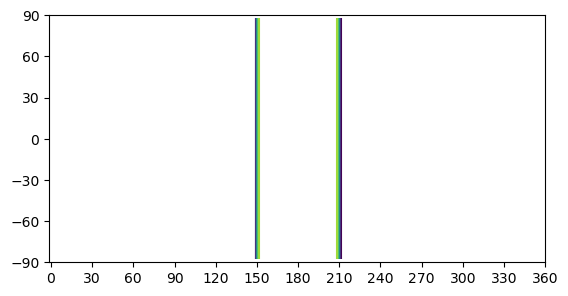

In [3]:
ds = isca_tools.load_dataset(exp_name)
lat_land, lon_land = isca_tools.utils.land.get_land_coords(namelist['experiment_details']['input_dir']+'/namelist.nml')
lat_ocean, lon_ocean = isca_tools.utils.land.get_ocean_coords(namelist['experiment_details']['input_dir']+'/namelist.nml')
# Land is strip over all latitudes so land longitudes have no overlap with ocean
ds_land = ds.sel(lon=lon_land, method="nearest")
ds_ocean = ds.sel(lon=lon_ocean, method="nearest")


ds = ds_land   # Change here to do analysis over land or over ocean
isca_tools.plot.show_land(namelist['experiment_details']['input_dir']+'/land.nc')

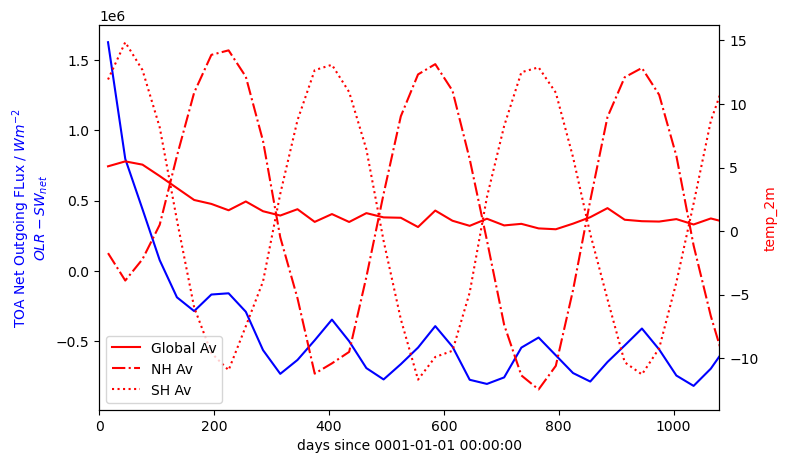

In [4]:
# Plot spin up time
fig, ax = plt.subplots(1,1, figsize=(8, 5))
isca_tools.plot.plot_spin_up(ds.olr, ds.swdn_toa*(1-albedo*np.exp(-tau)), ds.temp_2m, ax)
(isca_tools.utils.area_weighting(ds.temp_2m.sel(lat=slice(0,90))).mean(dim=['lon', 'lat'])- 273.15).plot(color='r', linestyle='-.')
(isca_tools.utils.area_weighting(ds.temp_2m.sel(lat=slice(-90,0))).mean(dim=['lon', 'lat'])- 273.15).plot(color='r', linestyle=':')
ax.set_xlim(0, 360*3);
plt.legend(['Global Av','NH Av', 'SH Av']);

## Moist static energy
Want to see whether moist static energy is conserved i.e. same at surface and in free troposphere for each latitude.

In [5]:
# Take zonal mean
# Use all data after 3 years, as clearly converged from the above spin up plot
ds_use = ds.sel(time=slice(360*3, np.inf)).mean(dim=['lon'])

In [6]:
# Get near surface moist static energy as function of latitude using 2m variables
mse_2m = moist_static_energy(2 * units.meters, ds_use.temp_2m * units.kelvin,
                             ds_use.sphum_2m * units.kilogram/units.kilogram)

In [7]:
# Sanity check to make sure that surface specific humidity is less than saturation specific humidity.
# I.e. check that saturation q calculation is correct
q_sat_2m = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_use.temp_2m * units.kelvin))
rh_2m = ds_use.sphum_2m / q_sat_2m
print("Max Surface Relative Humidity: {:.3f}".format(rh_2m.to_numpy().max()))

Max Surface Relative Humidity: 2.245


In [8]:
# Free troposphere MSE at 700hPa - units of pressure in dataset are hPa
ds_ft = ds_use.sel(pfull=500, method='nearest')
q_sat_ft = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_ft.temp * units.kelvin))
mse_ft = moist_static_energy(ds_ft.height * units.meters, ds_ft.temp * units.kelvin,
                             q_sat_ft * units.kilogram/units.kilogram)

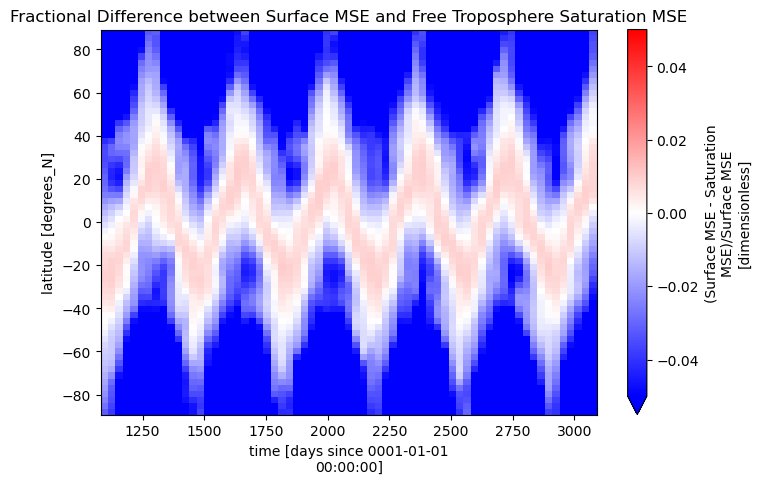

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
mse_diff = (mse_2m-mse_ft)/mse_2m
mse_diff.name = '(Surface MSE - Saturation MSE)/Surface MSE'
mse_diff.plot.pcolormesh(ax=ax, x='time', vmin=-0.05, vmax=0.05, cmap='bwr');
ax.set_title('Fractional Difference between Surface MSE and Free Troposphere Saturation MSE');

This plot shows that the moist static energy at the surface is not equal to the saturation moist static energy in the free troposphere, as we would expect if it was convectively coupled.

In [10]:
# Get datasets which only correspond to NH summer and NH winter
ds_summer_nh = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).mean(dim='time')    # NH summer is JJA
ds_summer_sh = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).mean(dim='time')   # SH summer is DJF

In [11]:
# Consider each latitude and pressure value and compute saturation MSE
hemisphere = 'north'
if hemisphere == 'north':
    ds_season = ds_summer_nh
else:
    ds_season = ds_summer_sh
mse_2m_season = moist_static_energy(2 * units.meters, ds_season.temp_2m * units.kelvin,
                                    ds_season.sphum_2m * units.kilogram/units.kilogram)
q_sat_all = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_season.temp * units.kelvin))
mse_all = moist_static_energy(ds_season.height * units.meters, ds_season.temp * units.kelvin,
                             q_sat_all * units.kilogram/units.kilogram)
mse_all.name = 'saturation moist static energy';

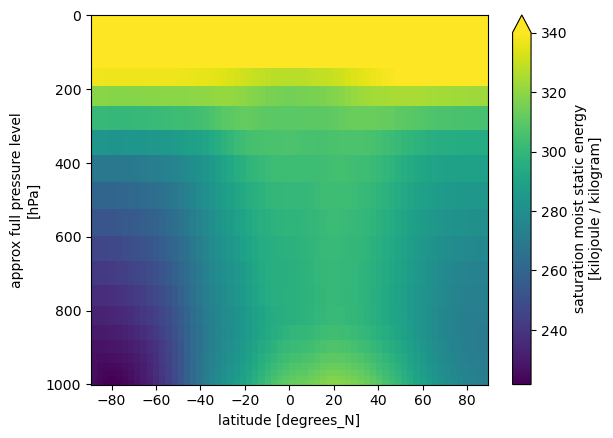

In [12]:
mse_all.plot(vmax=340, yincrease=False);

From this plot, it appears that in the tropics, the saturation MSE is constant from about 900hPa up to around 400hPa.

In [13]:
# Get data for plots
import warnings
# Fractional difference between surface MSE and saturation MSE at each pressure level
mse_diff = (mse_2m_season-mse_all)/mse_2m_season
mse_diff.name = '(Surface MSE - Saturation MSE)/Surface MSE'

# Tropical (|lat|<10) and extratropical (latitude between 40 and 60) lapse rates
trop_lapse = isca_tools.utils.area_weighting(ds_season.temp.sel(lat=slice(-10,10))).mean(dim='lat')
if hemisphere == 'north':
    lat_slice = slice(40,60)
else:
    lat_slice = slice(-60,40)
extrop_temp = ds_season.temp.sel(lat=lat_slice)
extrop_lapse = isca_tools.utils.area_weighting(extrop_temp).mean(dim='lat')

# Lapse rates which would occur if parcel followed dry adiabat to LCL followed by moist adiabat
trop_temp_2m = isca_tools.utils.area_weighting(ds_season.temp_2m.sel(lat=slice(-10,10))).mean(dim='lat')
trop_sphum_2m = isca_tools.utils.area_weighting(ds_season.sphum_2m.sel(lat=slice(-10,10))).mean(dim='lat')
trop_dew = dewpoint_from_specific_humidity(p_full*units.pascal, trop_temp_2m*units.kelvin,
                                           trop_sphum_2m*units.kilogram/units.kilogram)

extrop_temp_2m_all = ds_season.temp_2m.sel(lat=lat_slice)
extrop_sphum_2m_all = ds_season.sphum_2m.sel(lat=lat_slice)
extrop_temp_2m = isca_tools.utils.area_weighting(extrop_temp_2m_all).mean(dim='lat')
extrop_sphum_2m = isca_tools.utils.area_weighting(extrop_sphum_2m_all).mean(dim='lat')
extrop_dew = dewpoint_from_specific_humidity(p_full*units.pascal, extrop_temp_2m*units.kelvin,
                                           extrop_sphum_2m*units.kilogram/units.kilogram)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    trop_profile = parcel_profile(extrop_temp.pfull[::-1] * units.hectopascal, trop_temp_2m*units.kelvin, trop_dew);
    extrop_profile = parcel_profile(extrop_temp.pfull[::-1] * units.hectopascal, extrop_temp_2m*units.kelvin, extrop_dew);
trop_profile.name = 'Temperature'
extrop_profile.name = 'Temperature'

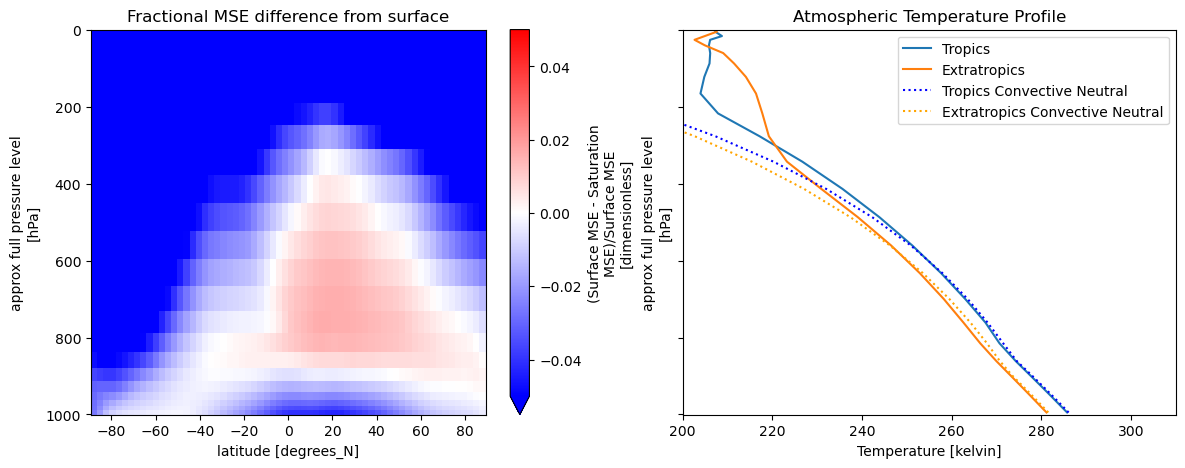

In [14]:
# Plot
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharey=True)
# Plot fractional difference between surface MSE and saturation MSE at each pressure level
mse_diff.plot.pcolormesh(ax=axs[0], yincrease=False, vmin=-0.05, vmax=0.05, cmap='bwr', x='lat');
# Plot tropical (|lat|<10) and extratropical lapse rates
trop_lapse.plot.line(ax=axs[1], yincrease=False, y='pfull', label='Tropics');
extrop_lapse.plot.line(ax=axs[1], yincrease=False, y='pfull', label='Extratropics');
# Plot Lapse rates which would occur if parcel followed dry adiabat to LCL followed by moist adiabat
trop_profile.plot.line(ax=axs[1], yincrease=False, y='pfull', label='Tropics Convective Neutral', color='b',linestyle=':')
extrop_profile.plot.line(ax=axs[1], yincrease=False, y='pfull', label='Extratropics Convective Neutral', color='orange',linestyle=':')

axs[1].legend();
axs[1].set_xlim([200, 310])
axs[0].set_title('Fractional MSE difference from surface');
axs[1].set_title('Atmospheric Temperature Profile');

The above plot shows the difference between surface moist static energy and saturation moist static energy at each pressure level.

In the tropics, near the surface, surface MSE > saturation MSE. This is probably because here, the lapse rate is the dry adiabat so temperatures are decreasing rapidly with altitude and hence saturation MSE also decreases rapidly with altitude.

Above around 900hPa though, saturation MSE > surface MSE. This is probably because here the temperature is following the moist adiabat and so decreases less rapidly with altitude. I.e. the increase in geopotential height outweighs the decrease in temperature.

In the entire red region, which encompasses the free troposphere of the tropics, we see that the MSE is within 5% of the surface MSE.

Comparing the two plots above, it appears that in both the tropics and extratropics, the saturation MSE is slightly above the surface MSE for all pressure levels where the temperature profile follows that predicted by convective neutrality.

For the tropics ($|\phi| \leq 10$), this is up to 200hPa and for the extratropics ($40 \leq |\phi| \leq 60$), this is up to around 700hPa.